Credits: https://github.com/Holmes-Alan/SIFT_ImgMatch/blob/main

Load required library

In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt

In [2]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

In [3]:
# Define a list of images you want to test

imageList = ["book1.jpg", "book2.jpg", "eiffel.jpg", "superman.jpg"]



In [4]:
# We use grayscale images for generating keypoints
imagesBW = []
for imageName in imageList:
    imagePath = str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale

In [5]:
# Using opencv's sift implementation here

sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [6]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    if imageList[i] == "book1.jpg":
        print("  Skipping image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])

Starting for image: book1.jpg
  Skipping image: book1.jpg
  Ending for image: book1.jpg
Starting for image: book2.jpg
  Ending for image: book2.jpg
Starting for image: eiffel.jpg
  Ending for image: eiffel.jpg
Starting for image: superman.jpg
  Ending for image: superman.jpg


In [7]:
for i, keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)

In [8]:
for i,descriptor in enumerate(descriptors):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)

**Task 1:** Define a reasonable threshold for the similarity between two image-keypoints

In [9]:
threshold = 0.75
def FilterMatches(matches, mode='selection'):
    '''
        Implements different options to filter matches.
            - 'sort' will simply sort them by similarity distance.
            - 'ratio' will employ the ratio test as in Lowe's paper
    '''
    if(mode == 'sort'):
        selection = sorted(matches, key = lambda x:x[0].distance)
    if(mode == 'ratio'):
        selection = [[m] for m, n in matches if m.distance < threshold*n.distance]

    return selection

Fetch Keypoints and Descriptors from stored files

In [10]:
def fetchKeypointFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

In [11]:
# Calculate Results for any pair
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    """
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults1.append([m])
    """
    topResults1 = FilterMatches(matches, mode='ratio')
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = FilterMatches(matches, mode='ratio')
    '''
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults2.append([m])
    '''
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

# scoring metric, a score greater than 10 means very good
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

# draw KNN matching plot
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 255, 0],
        flags=0
    )
    return matchPlot

def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread(imageList[i]))
    image2 = imageResizeTest(cv2.imread(imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

# calculate matching results for any two images
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(f"Match paires: {len(matches)}, Keypoints in img1: {len(keypoint1)}, Keypoints in img2: {len(keypoint2)}")
    print(f"Matching score is: {score}%")
    plt.imshow(plot),plt.show()

Calculate the SIFT matches between images

Match paires: 6, Keypoints in img1: 2236, Keypoints in img2: 1620
Matching score is: 0.3703703703703704%


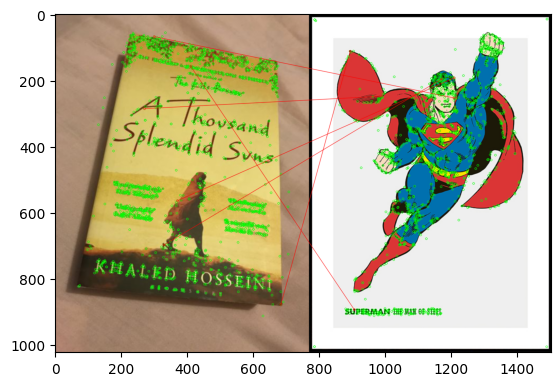

In [12]:
calculateResultsFor(0, 3) # calculate results for image 1 and image 4 (book1 and superman)
# Add tests between each image pair

**Task 2:** Redo the SIFT with all the images (including the 'book1_masked')